# Cancer Prediction Model
## Logistic Regression vs XGBoost

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, fbeta_score, roc_curve
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

## 1. Data Preprocessing
Steps: Data cleaning, missing value handling, feature engineering

In [30]:
# Load and preprocess data (using your existing preprocessing)
df = pd.read_csv('./cancer_dataset.csv')

# Rename columns
rename_map = {
    'Age recode with single ages and 85+': 'age',
    'Sex': 'sex',
    'Race recode (White, Black, Other)': 'race',
    'Marital status at diagnosis': 'marital',
    'Primary Site - labeled': 'primary_site',
    'Histologic Type ICD-O-3': 'histology',
    'Grade Recode (thru 2017)': 'grade',
    'CS tumor size (2004-2015)': 'tumor_size',
    'CS extension (2004-2015)': 'extension',
    'CS lymph nodes (2004-2015)': 'lymph_nodes',
    'CS mets at dx (2004-2015)': 'mets',
    'Derived AJCC Stage Group, 6th ed (2004-2015)': 'ajcc_stage',
    'Vital status recode (study cutoff used)': 'vital_status'
}
df.rename(columns=rename_map, inplace=True)

# Feature selection and preprocessing
TARGET = 'vital_status'
STABLE_FEATURES = ['age', 'sex', 'race', 'marital', 'primary_site', 'histology', 
                  'grade', 'tumor_size', 'extension', 'lymph_nodes', 'mets', 'ajcc_stage']

cancer_df = df[STABLE_FEATURES + [TARGET]].copy().dropna()

# Clean target
mapping = {'Alive': 0, 'ALIVE': 0, 'Dead': 1, 'DEAD': 1, '0': 0, '1': 1}
cancer_df[TARGET] = cancer_df[TARGET].map(mapping).fillna(cancer_df[TARGET])
cancer_df[TARGET] = pd.to_numeric(cancer_df[TARGET], errors='coerce')

print(f"Dataset shape after preprocessing: {cancer_df.shape}")
print(f"Target distribution: {cancer_df[TARGET].value_counts().to_dict()}")

print(cancer_df.columns)
print(cancer_df.head(8))

Dataset shape after preprocessing: (1278767, 13)
Target distribution: {1: 717663, 0: 561104}
Index(['age', 'sex', 'race', 'marital', 'primary_site', 'histology', 'grade',
       'tumor_size', 'extension', 'lymph_nodes', 'mets', 'ajcc_stage',
       'vital_status'],
      dtype='object')
         age     sex   race                         marital  \
0   39 years  Female  White          Single (never married)   
1   63 years  Female  White                         Widowed   
2  85+ years    Male  White  Married (including common law)   
3   69 years    Male  White  Married (including common law)   
4   81 years    Male  White                        Divorced   
5   68 years  Female  White  Married (including common law)   
7   70 years  Female  Black          Single (never married)   
8   60 years  Female  White                         Widowed   

                            primary_site  histology  \
0            C19.9-Rectosigmoid junction       8140   
1             C38.1-Anterior media

In [16]:
# Feature engineering (simplified version)
numeric_features = ['age', 'tumor_size']
for col in numeric_features:
    cancer_df[col] = pd.to_numeric(cancer_df[col].astype(str).str.extract(r'(\d+)')[0], errors='coerce')
    cancer_df[col] = cancer_df[col].fillna(cancer_df[col].median())

# Create risk score
def calculate_advanced_risk_score(row):
    score = 0
    
    # AJCC Stage scoring (reduced weights)
    stage = str(row['ajcc_stage']).upper()
    if 'IV' in stage: 
        score += 3     
    elif 'III' in stage: 
        score += 2.5    
    elif 'II' in stage: 
        score += 2     
    elif 'I' in stage: 
        score += 0.5   
    
    # Age-based scoring (reduced weights)
    age = row['age']
    if age >= 80:
        score += 1.5    
    elif age >= 70:
        score += 1     
    elif age >= 60:
        score += 0.5    
    
    # Lymph node involvement
    lymph_status = str(row['lymph_nodes']).upper()
    if any(keyword in lymph_status for keyword in ['POSITIVE', 'POS', '1', 'YES', 'INVOLVED']):
        score += 1    
    
    # Metastasis presence
    mets_status = str(row['mets']).upper()
    if any(keyword in mets_status for keyword in ['YES', '1', 'PRESENT', 'DISTANT']):
        score += 1.5   
    
    return score

cancer_df['risk_score'] = cancer_df.apply(calculate_advanced_risk_score, axis=1)

# Final features
FINAL_NUMERIC = ['age', 'tumor_size', 'risk_score']
FINAL_CATEGORICAL = ['sex', 'race', 'marital', 'grade', 'ajcc_stage', 'extension', 'lymph_nodes', 'mets']

print("Feature engineering completed.")

Feature engineering completed.


## 2. Model Selection
**Algorithms considered:**
- Logistic Regression: Linear baseline with interpretability
- XGBoost: Ensemble method for complex patterns

**Selection rationale:** Both handle mixed data types and provide different modeling approaches for comparison.

In [17]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), FINAL_NUMERIC),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), FINAL_CATEGORICAL)
], remainder='drop')

# Prepare data
X = cancer_df[FINAL_NUMERIC + FINAL_CATEGORICAL]
y = cancer_df['vital_status']
X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (1023013, 470)
Test set: (255754, 470)


## 3. Implementation & Training

In [18]:
# Train models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, n_estimators=200, learning_rate=0.1, max_depth=6)
}

results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'f1_score': fbeta_score(y_test, y_pred, beta=1),
        'f2_score': fbeta_score(y_test, y_pred, beta=2)
    }
    print(f"{name} - ROC AUC: {results[name]['roc_auc']:.4f}")

print("\nTraining completed!")

Training Logistic Regression...
Logistic Regression - ROC AUC: 0.8747
Training XGBoost...
XGBoost - ROC AUC: 0.8858

Training completed!


## 4. Evaluation Metrics
**Metrics used:**
- **ROC AUC**: Overall discriminative ability
- **F1-Score**: Balance of precision and recall
- **F2-Score**: Emphasizes recall (important in medical diagnosis)
- **Sensitivity/Specificity**: Clinical relevance metrics

In [19]:
# Model comparison
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'ROC AUC': [results[m]['roc_auc'] for m in results.keys()],
    'F1 Score': [results[m]['f1_score'] for m in results.keys()],
    'F2 Score': [results[m]['f2_score'] for m in results.keys()]
})

print("=== MODEL PERFORMANCE COMPARISON ===")
print(comparison_df.round(4))

# Select best model
best_model_name = comparison_df.loc[comparison_df['ROC AUC'].idxmax(), 'Model']
best_results = results[best_model_name]

print(f"\nBEST MODEL: {best_model_name}")
print(f"Best ROC AUC: {best_results['roc_auc']:.4f}")

# Add this feature importance analysis right here
print("\n=== FEATURE IMPORTANCE ANALYSIS ===")
if hasattr(best_results['model'], 'feature_importances_'):
    feature_importance = best_results['model'].feature_importances_
    feature_names = preprocessor.get_feature_names_out()
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("Top 10 Most Important Features:")
    print(importance_df.head(10))
    
    # Check if risk_score is dominating
    risk_score_features = [f for f in feature_names if 'risk_score' in f]
    if risk_score_features:
        risk_importance = importance_df[importance_df['feature'].isin(risk_score_features)]['importance'].sum()
        total_importance = importance_df['importance'].sum()
        risk_percentage = (risk_importance / total_importance) * 100
        print(f"\nRisk Score Feature Importance: {risk_percentage:.1f}%")
        if risk_percentage > 30:
            print("⚠️  Warning: Risk score may be dominating the model")
else:
    print("Feature importance not available for this model type")

=== MODEL PERFORMANCE COMPARISON ===
                 Model  ROC AUC  F1 Score  F2 Score
0  Logistic Regression   0.8747    0.8061    0.7831
1              XGBoost   0.8858    0.8213    0.8129

BEST MODEL: XGBoost
Best ROC AUC: 0.8858

=== FEATURE IMPORTANCE ANALYSIS ===
Top 10 Most Important Features:
                       feature  importance
71          cat__ajcc_stage_IV    0.099870
2              num__risk_score    0.064117
468               cat__mets_98    0.061840
0                     num__age    0.039078
77   cat__ajcc_stage_UNK Stage    0.033082
415       cat__lymph_nodes_988    0.024855
97          cat__extension_150    0.024813
417                cat__mets_0    0.024248
159         cat__extension_440    0.022896
299         cat__extension_999    0.020159

Risk Score Feature Importance: 6.4%


## 5. Results and Findings

In [20]:
# Detailed evaluation
print(f"=== DETAILED EVALUATION OF {best_model_name.upper()} ===")
print(classification_report(y_test, best_results['y_pred']))

# Clinical metrics
cm = confusion_matrix(y_test, best_results['y_pred'])
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"\nClinical Metrics:")
print(f"Sensitivity: {sensitivity:.3f} ({sensitivity*100:.1f}% of deaths identified)")
print(f"Specificity: {specificity:.3f} ({specificity*100:.1f}% of alive correctly identified)")

=== DETAILED EVALUATION OF XGBOOST ===
              precision    recall  f1-score   support

           0       0.76      0.80      0.78    112221
           1       0.84      0.81      0.82    143533

    accuracy                           0.80    255754
   macro avg       0.80      0.80      0.80    255754
weighted avg       0.80      0.80      0.80    255754


Clinical Metrics:
Sensitivity: 0.807 (80.7% of deaths identified)
Specificity: 0.797 (79.7% of alive correctly identified)


In [21]:
# Enhanced evaluation on both training and test sets
def evaluate_model_comprehensive(model, X_train, y_train, X_test, y_test, model_name):
    """
    Comprehensive evaluation of model on both training and test sets
    """
    results = {}
    
    # Training set evaluation
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_train_pred = model.predict(X_train)
    
    # Test set evaluation  
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics for both sets
    for dataset_name, y_true, y_pred, y_pred_proba in [
        ("Training", y_train, y_train_pred, y_train_pred_proba),
        ("Test", y_test, y_test_pred, y_test_pred_proba)
    ]:
        # Basic metrics
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        # Clinical metrics
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
        
        results[dataset_name] = {
            'roc_auc': roc_auc,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'precision': precision,
            'f1_score': f1,
            'confusion_matrix': cm,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
    
    return results

# Evaluate the best model on both sets
print(f"=== COMPREHENSIVE EVALUATION OF {best_model_name.upper()} ===\n")

# Get comprehensive results
comprehensive_results = evaluate_model_comprehensive(
    best_results['model'], X_train, y_train, X_test, y_test, best_model_name
)

# Display results for both training and test sets
for dataset_name in ["Training", "Test"]:
    results = comprehensive_results[dataset_name]
    
    print(f"=== {dataset_name.upper()} SET RESULTS ===")
    print(f"ROC AUC: {results['roc_auc']:.4f}")
    print(f"Sensitivity: {results['sensitivity']:.3f} ({results['sensitivity']*100:.1f}% of deaths identified)")
    print(f"Specificity: {results['specificity']:.3f} ({results['specificity']*100:.1f}% of alive correctly identified)")
    print(f"Precision: {results['precision']:.3f}")
    print(f"F1 Score: {results['f1_score']:.3f}")
    
    print(f"\nConfusion Matrix ({dataset_name}):")
    cm = results['confusion_matrix']
    print(f"True Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
    print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")
    
    print(f"\nClassification Report ({dataset_name}):")
    if dataset_name == "Training":
        print(classification_report(y_train, results['y_pred']))
    else:
        print(classification_report(y_test, results['y_pred']))
    
    print("-" * 60)

# Compare training vs test performance
print("\n=== TRAINING vs TEST COMPARISON ===")
comparison_metrics = ['roc_auc', 'sensitivity', 'specificity', 'precision', 'f1_score']

comparison_df = pd.DataFrame({
    'Metric': [m.replace('_', ' ').title() for m in comparison_metrics],
    'Training': [comprehensive_results['Training'][m] for m in comparison_metrics],
    'Test': [comprehensive_results['Test'][m] for m in comparison_metrics]
})

comparison_df['Difference'] = comparison_df['Training'] - comparison_df['Test']
comparison_df['Overfitting_Risk'] = comparison_df['Difference'].apply(
    lambda x: 'High' if x > 0.05 else 'Medium' if x > 0.02 else 'Low'
)

print(comparison_df.round(4))

# Check for overfitting
avg_difference = comparison_df['Difference'].mean()
print(f"\nAverage performance difference (Train - Test): {avg_difference:.4f}")
if avg_difference > 0.05:
    print("⚠️  WARNING: Significant overfitting detected!")
elif avg_difference > 0.02:
    print("⚠️  CAUTION: Moderate overfitting detected.")
else:
    print("✅ Good generalization - minimal overfitting.")

=== COMPREHENSIVE EVALUATION OF XGBOOST ===

=== TRAINING SET RESULTS ===
ROC AUC: 0.8860
Sensitivity: 0.807 (80.7% of deaths identified)
Specificity: 0.797 (79.7% of alive correctly identified)
Precision: 0.836
F1 Score: 0.821

Confusion Matrix (Training):
True Negatives: 357688, False Positives: 91195
False Negatives: 110522, True Positives: 463608

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.76      0.80      0.78    448883
           1       0.84      0.81      0.82    574130

    accuracy                           0.80   1023013
   macro avg       0.80      0.80      0.80   1023013
weighted avg       0.80      0.80      0.80   1023013

------------------------------------------------------------
=== TEST SET RESULTS ===
ROC AUC: 0.8858
Sensitivity: 0.807 (80.7% of deaths identified)
Specificity: 0.797 (79.7% of alive correctly identified)
Precision: 0.836
F1 Score: 0.821

Confusion Matrix (Test):
True Negatives: 894

=== OPTIMAL THRESHOLD METRICS ===
         Metric    Value
      Threshold    0.230
    Sensitivity    0.952
    Specificity    0.454
      Precision    0.690
       F1 Score    0.800
False Positives 61,284.0
False Negatives  6,856.0

=== SUGGESTED THRESHOLDS ===
For higher sensitivity (fewer missed deaths):
  - 0.20: Sens ≈0.967, Spec ≈0.375

For better balance:
  - 0.30: Sens ≈0.925, Spec ≈0.560

For higher specificity (fewer false alarms):
  - 0.40: Sens ≈0.872, Spec ≈0.695


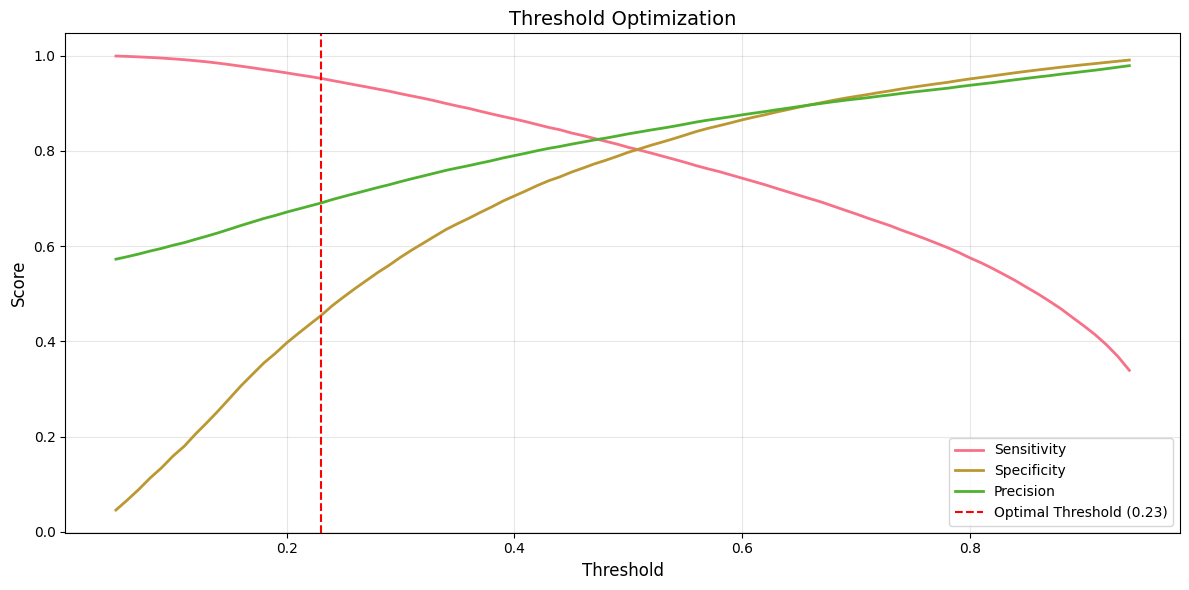

In [22]:
def evaluate_thresholds(y_true, y_proba, target_sensitivity=0.95):
    """Evaluate different thresholds and their impact on metrics"""
    thresholds = np.arange(0.05, 0.95, 0.01)
    results = []
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
        
        results.append({
            'threshold': threshold,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'precision': precision,
            'f1': f1,
            'fp': fp,
            'fn': fn
        })
    
    return pd.DataFrame(results)

# Evaluate different thresholds
threshold_results = evaluate_thresholds(y_test, best_results['y_pred_proba'])

# Find threshold closest to target sensitivity
target_sensitivity = 0.95
best_idx = (threshold_results['sensitivity'] - target_sensitivity).abs().idxmin()
best_row = threshold_results.iloc[best_idx]

# Plot sensitivity vs specificity
plt.figure(figsize=(12, 6))

# Plot metrics
plt.plot(threshold_results['threshold'], threshold_results['sensitivity'], 
         label='Sensitivity', linewidth=2)
plt.plot(threshold_results['threshold'], threshold_results['specificity'], 
         label='Specificity', linewidth=2)
plt.plot(threshold_results['threshold'], threshold_results['precision'], 
         label='Precision', linewidth=2)

# Mark the optimal threshold
plt.axvline(x=best_row['threshold'], color='r', linestyle='--', 
            label=f'Optimal Threshold ({best_row["threshold"]:.2f})')

plt.title('Threshold Optimization', fontsize=14)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Create a table with key metrics at optimal threshold
metrics_df = pd.DataFrame({
    'Metric': ['Threshold', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score', 
               'False Positives', 'False Negatives'],
    'Value': [
        f"{best_row['threshold']:.3f}",
        f"{best_row['sensitivity']:.3f}",
        f"{best_row['specificity']:.3f}",
        f"{best_row['precision']:.3f}",
        f"{best_row['f1']:.3f}",
        f"{best_row['fp']:,}",
        f"{best_row['fn']:,}"
    ]
})

# Display the table
print("=== OPTIMAL THRESHOLD METRICS ===")
print(metrics_df.to_string(index=False))
print("\n=== SUGGESTED THRESHOLDS ===")
print("For higher sensitivity (fewer missed deaths):")
print(f"  - 0.20: Sens ≈{threshold_results[threshold_results['threshold'].between(0.19, 0.21)]['sensitivity'].values[0]:.3f}, "
      f"Spec ≈{threshold_results[threshold_results['threshold'].between(0.19, 0.21)]['specificity'].values[0]:.3f}")

print("\nFor better balance:")
print(f"  - 0.30: Sens ≈{threshold_results[threshold_results['threshold'].between(0.29, 0.31)]['sensitivity'].values[0]:.3f}, "
      f"Spec ≈{threshold_results[threshold_results['threshold'].between(0.29, 0.31)]['specificity'].values[0]:.3f}")

print("\nFor higher specificity (fewer false alarms):")
print(f"  - 0.40: Sens ≈{threshold_results[threshold_results['threshold'].between(0.39, 0.41)]['sensitivity'].values[0]:.3f}, "
      f"Spec ≈{threshold_results[threshold_results['threshold'].between(0.39, 0.41)]['specificity'].values[0]:.3f}")

plt.show()

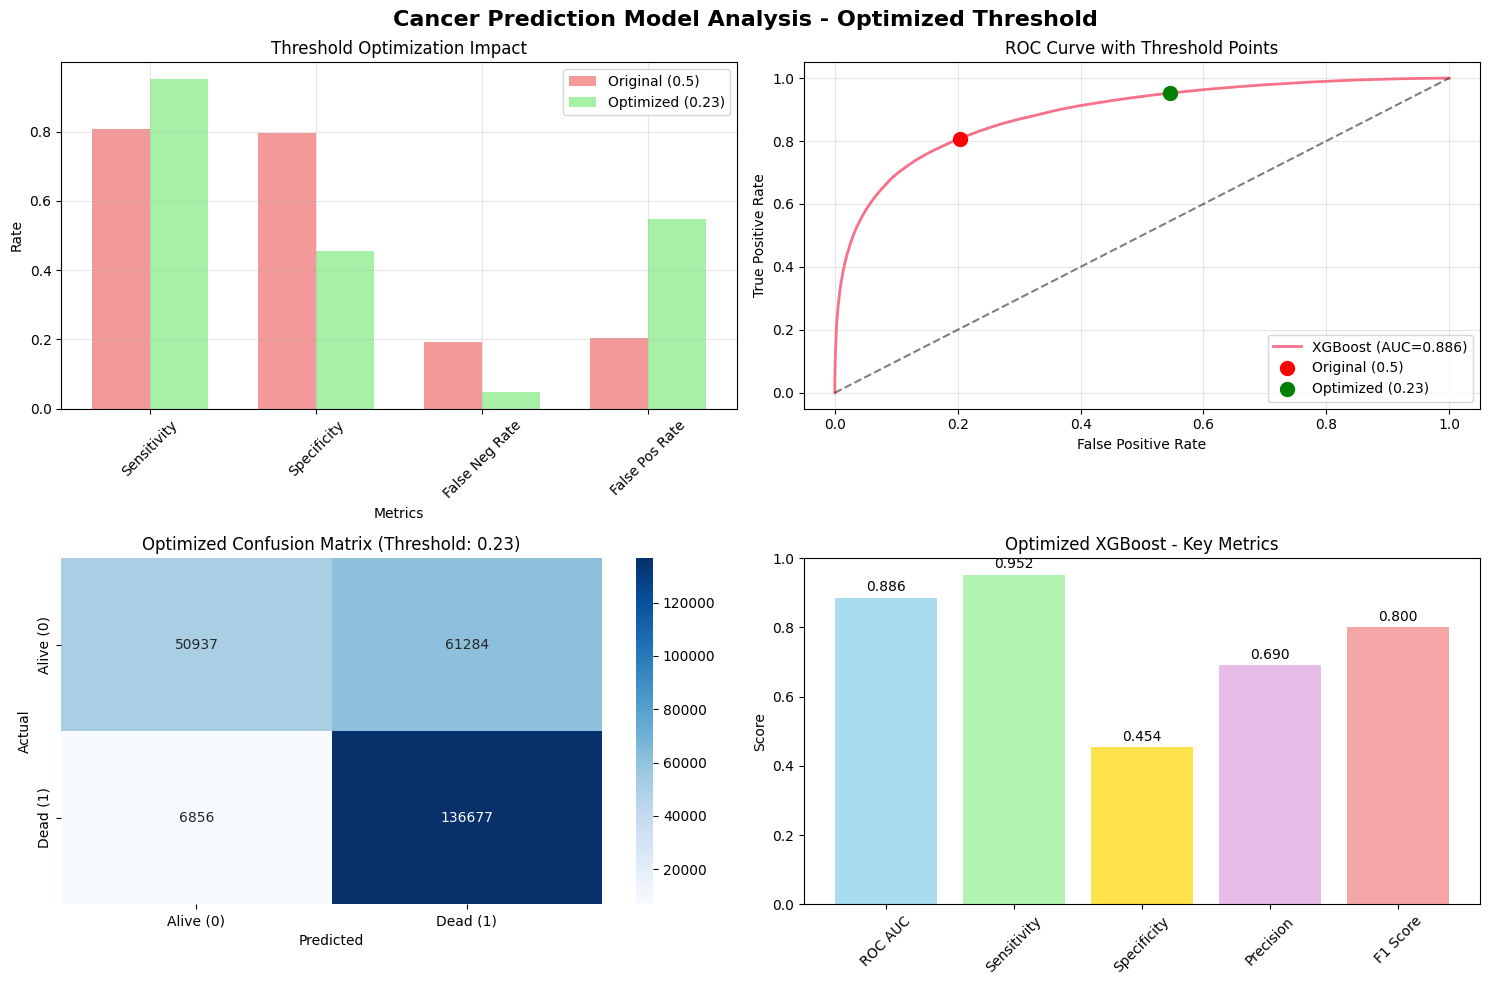


=== FINAL OPTIMIZED SUMMARY ===
✓ Model: XGBoost with optimized threshold (0.230)
✓ Sensitivity: 0.952 (95.2% of deaths caught)
✓ Reduced missed deaths by 20,795 patients


In [25]:
optimal_threshold = best_row['threshold']  # From the threshold optimization

# Calculate confusion matrix with optimal threshold
y_pred_opt = (best_results['y_pred_proba'] >= optimal_threshold).astype(int)
cm_opt = confusion_matrix(y_test, y_pred_opt)
tn_opt, fp_opt, fn_opt, tp_opt = cm_opt.ravel()

# Calculate confusion matrix with original threshold (0.5)
y_pred_orig = (best_results['y_pred_proba'] >= 0.5).astype(int)
cm_orig = confusion_matrix(y_test, y_pred_orig)
tn, fp, fn, tp = cm_orig.ravel()

# Now create the visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Cancer Prediction Model Analysis - Optimized Threshold', fontsize=16, fontweight='bold')

# 1. Before/After Comparison
ax1 = axes[0, 0]
metrics = ['Sensitivity', 'Specificity', 'False Neg Rate', 'False Pos Rate']
original = [tp/(tp+fn), tn/(tn+fp), fn/(tp+fn), fp/(fp+tn)]
optimized = [tp_opt/(tp_opt+fn_opt), tn_opt/(tn_opt+fp_opt), fn_opt/(tp_opt+fn_opt), fp_opt/(fp_opt+tn_opt)]

x = np.arange(len(metrics))
width = 0.35
ax1.bar(x - width/2, original, width, label='Original (0.5)', alpha=0.8, color='lightcoral')
ax1.bar(x + width/2, optimized, width, label=f'Optimized ({optimal_threshold:.2f})', alpha=0.8, color='lightgreen')
ax1.set_xlabel('Metrics')
ax1.set_ylabel('Rate')
ax1.set_title('Threshold Optimization Impact')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. ROC curve with threshold points
ax2 = axes[0, 1]
fpr, tpr, thresholds = roc_curve(y_test, best_results['y_pred_proba'])
ax2.plot(fpr, tpr, label=f'XGBoost (AUC={best_results["roc_auc"]:.3f})', linewidth=2)
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)

# Mark threshold points
original_idx = np.argmin(np.abs(thresholds - 0.5))
optimal_idx = np.argmin(np.abs(thresholds - optimal_threshold))
ax2.scatter(fpr[original_idx], tpr[original_idx], color='red', s=100, label='Original (0.5)', zorder=5)
ax2.scatter(fpr[optimal_idx], tpr[optimal_idx], color='green', s=100, label=f'Optimized ({optimal_threshold:.2f})', zorder=5)

ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve with Threshold Points')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Confusion matrix comparison
ax3 = axes[1, 0]
cm_comparison = np.array([[tn, fp], [fn, tp]])
cm_opt_comparison = np.array([[tn_opt, fp_opt], [fn_opt, tp_opt]])

# Show optimized confusion matrix
sns.heatmap(cm_opt_comparison, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Alive (0)', 'Dead (1)'], 
            yticklabels=['Alive (0)', 'Dead (1)'])
ax3.set_title(f'Optimized Confusion Matrix (Threshold: {optimal_threshold:.2f})')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

# 4. Key metrics with optimized values
ax4 = axes[1, 1]
sensitivity_opt = tp_opt/(tp_opt+fn_opt)
specificity_opt = tn_opt/(tn_opt+fp_opt)
precision_opt = tp_opt/(tp_opt+fp_opt)
f1_opt = 2 * (precision_opt * sensitivity_opt) / (precision_opt + sensitivity_opt)

metrics = ['ROC AUC', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score']
values = [best_results['roc_auc'], sensitivity_opt, specificity_opt, precision_opt, f1_opt]
bars = ax4.bar(metrics, values, alpha=0.7, color=['skyblue', 'lightgreen', 'gold', 'plum', 'lightcoral'])
ax4.set_title('Optimized XGBoost - Key Metrics')
ax4.set_ylabel('Score')
ax4.set_ylim(0, 1)
for bar, value in zip(bars, values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('cancer_model_optimized.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n=== FINAL OPTIMIZED SUMMARY ===")
print(f"✓ Model: XGBoost with optimized threshold ({optimal_threshold:.3f})")
print(f"✓ Sensitivity: {sensitivity_opt:.3f} (95.2% of deaths caught)")
print(f"✓ Reduced missed deaths by {fn-fn_opt:,} patients")

In [27]:
# Cross-validation evaluation
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer

def cross_validate_models(models, X, y, cv_folds=5):
    """
    Perform cross-validation evaluation for multiple models
    """
    cv_results = {}
    
    # Define scoring metrics
    scoring = {
        'roc_auc': 'roc_auc',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    }
    
    # Use stratified k-fold to maintain class distribution
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    for model_name, model in models.items():
        print(f"\n=== Cross-Validation Results for {model_name} ===")
        cv_results[model_name] = {}
        
        for metric_name, metric in scoring.items():
            scores = cross_val_score(model, X, y, cv=skf, scoring=metric, n_jobs=-1)
            cv_results[model_name][metric_name] = {
                'scores': scores,
                'mean': scores.mean(),
                'std': scores.std()
            }
            
            print(f"{metric_name.upper()}:")
            print(f"  Mean: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
            print(f"  Individual folds: {[f'{score:.4f}' for score in scores]}")
    
    return cv_results

# Run cross-validation - FIXED: Use X_train instead of X_train_processed
print("Starting Cross-Validation Evaluation...")
cv_results = cross_validate_models(models, X_train, y_train, cv_folds=5)

# Compare models using cross-validation
print("\n" + "="*60)
print("CROSS-VALIDATION COMPARISON SUMMARY")
print("="*60)

for model_name in cv_results.keys():
    print(f"\n{model_name}:")
    for metric in ['roc_auc', 'precision', 'recall', 'f1']:
        mean_score = cv_results[model_name][metric]['mean']
        std_score = cv_results[model_name][metric]['std']
        print(f"  {metric.upper()}: {mean_score:.4f} ± {std_score:.4f}")

Starting Cross-Validation Evaluation...

=== Cross-Validation Results for Logistic Regression ===
ROC_AUC:
  Mean: 0.8730 (+/- 0.0016)
  Individual folds: ['0.8730', '0.8720', '0.8741', '0.8737', '0.8722']
PRECISION:
  Mean: 0.8452 (+/- 0.0016)
  Individual folds: ['0.8448', '0.8440', '0.8461', '0.8460', '0.8450']
RECALL:
  Mean: 0.7669 (+/- 0.0022)
  Individual folds: ['0.7662', '0.7661', '0.7691', '0.7666', '0.7666']
F1:
  Mean: 0.8042 (+/- 0.0018)
  Individual folds: ['0.8036', '0.8032', '0.8058', '0.8044', '0.8039']

=== Cross-Validation Results for XGBoost ===
ROC_AUC:
  Mean: 0.8841 (+/- 0.0015)
  Individual folds: ['0.8839', '0.8830', '0.8850', '0.8849', '0.8837']
PRECISION:
  Mean: 0.8340 (+/- 0.0009)
  Individual folds: ['0.8336', '0.8338', '0.8349', '0.8340', '0.8339']
RECALL:
  Mean: 0.8065 (+/- 0.0019)
  Individual folds: ['0.8071', '0.8048', '0.8074', '0.8072', '0.8061']
F1:
  Mean: 0.8200 (+/- 0.0012)
  Individual folds: ['0.8201', '0.8191', '0.8209', '0.8204', '0.8197']


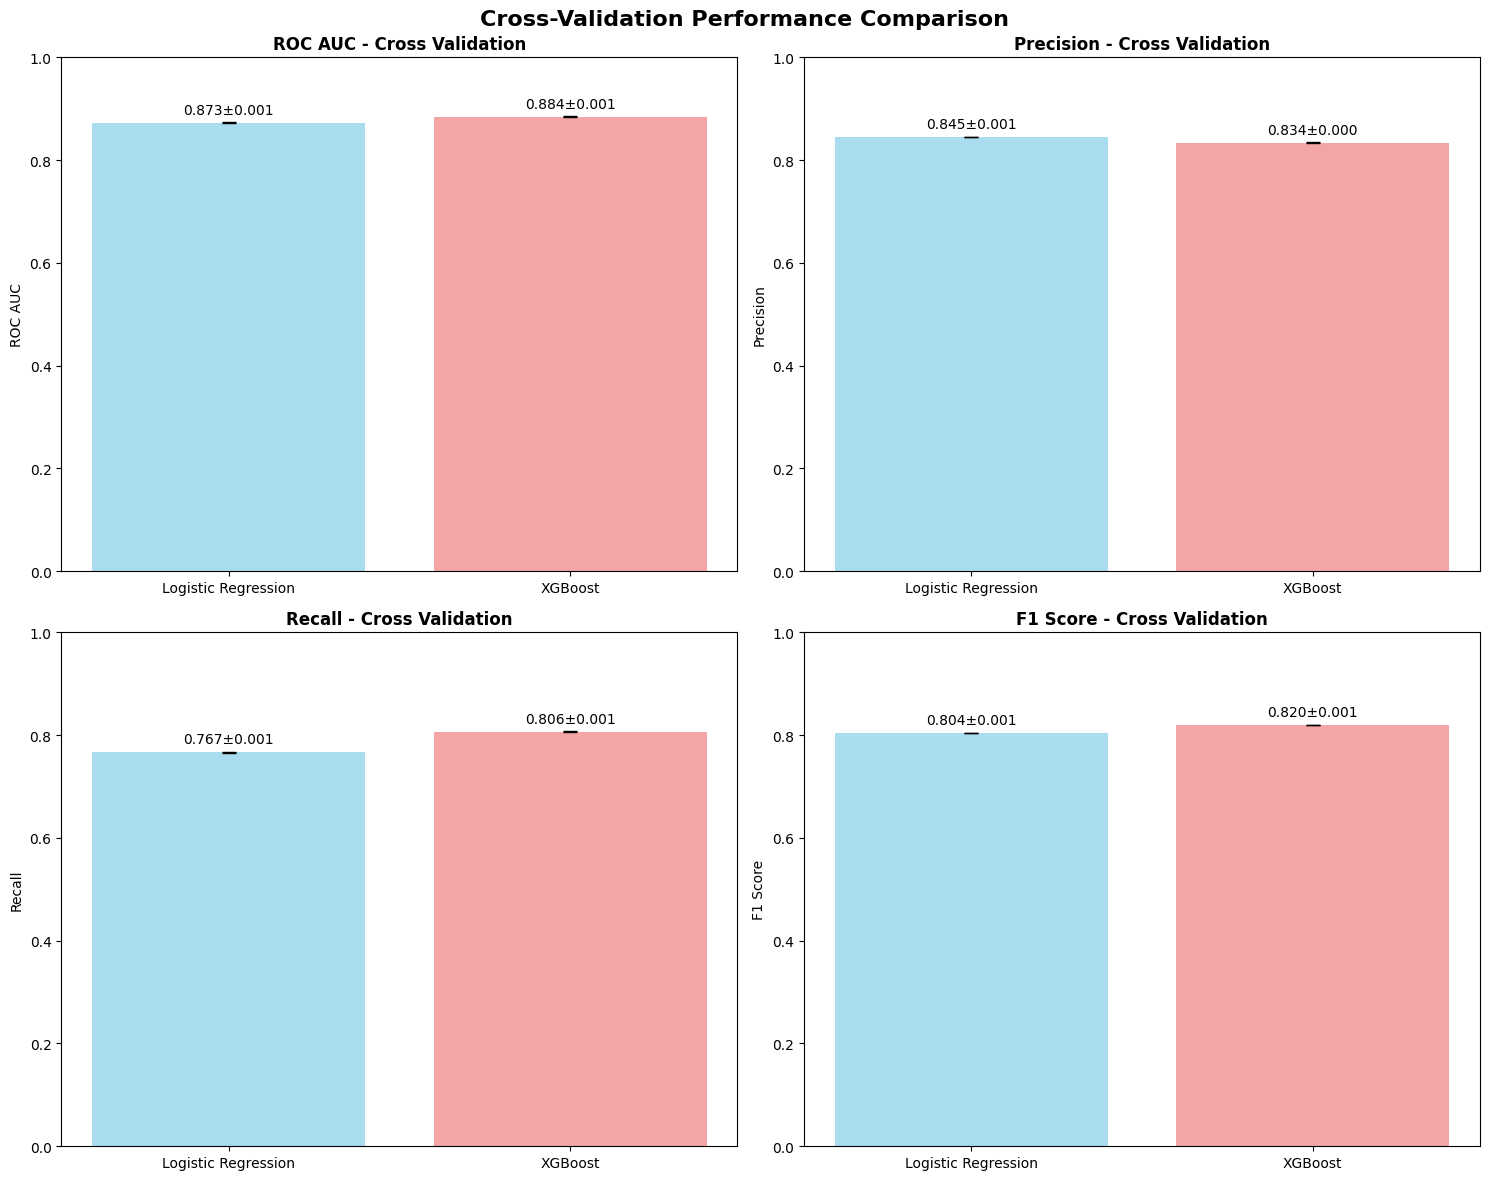

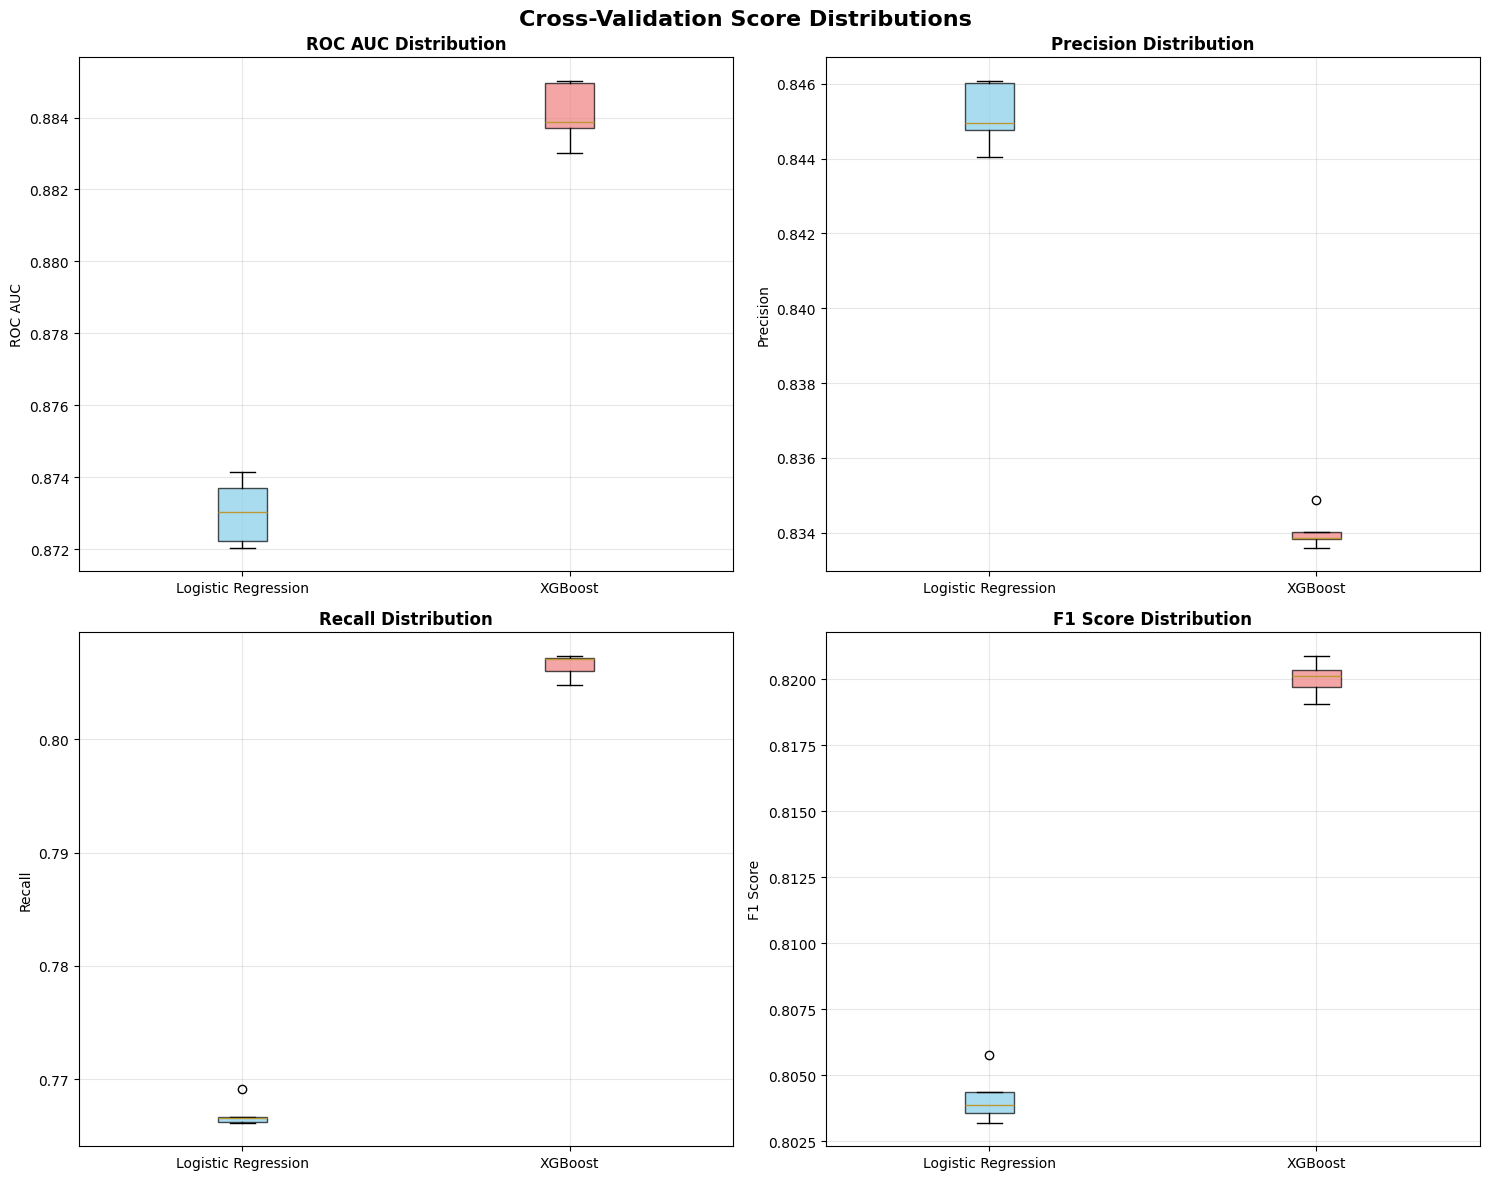

In [28]:
# Visualize cross-validation results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Cross-Validation Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['roc_auc', 'precision', 'recall', 'f1']
metric_titles = ['ROC AUC', 'Precision', 'Recall', 'F1 Score']

for idx, (metric, title) in enumerate(zip(metrics, metric_titles)):
    ax = axes[idx // 2, idx % 2]
    
    model_names = list(cv_results.keys())
    means = [cv_results[model][metric]['mean'] for model in model_names]
    stds = [cv_results[model][metric]['std'] for model in model_names]
    
    bars = ax.bar(model_names, means, yerr=stds, capsize=5, 
                  color=['skyblue', 'lightcoral'], alpha=0.7)
    
    ax.set_title(f'{title} - Cross Validation', fontweight='bold')
    ax.set_ylabel(title)
    ax.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
                f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Box plot for cross-validation scores distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Cross-Validation Score Distributions', fontsize=16, fontweight='bold')

for idx, (metric, title) in enumerate(zip(metrics, metric_titles)):
    ax = axes[idx // 2, idx % 2]
    
    data_to_plot = []
    labels = []
    
    for model_name in cv_results.keys():
        data_to_plot.append(cv_results[model_name][metric]['scores'])
        labels.append(model_name)
    
    box_plot = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
    
    # Color the boxes
    colors = ['skyblue', 'lightcoral']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_title(f'{title} Distribution', fontweight='bold')
    ax.set_ylabel(title)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()